# Screening Frequency Sensitivity Analysis

This notebook runs the glaucoma model analysis **three times** with different screening frequencies:

1. **One-time screening**: AI screening cost applied once at year 0 (base case)
2. **Biennial screening**: AI screening cost applied every 2 years (years 0, 2, 4, 6, ...)
3. **Annual screening**: AI screening cost applied every year

The analysis compares AI-enhanced vs traditional glaucoma screening across all three frequency scenarios.

---

### 📊 Analysis Setup

All other parameters remain constant across scenarios - only the screening frequency varies. This allows us to isolate the impact of repeated screening on cost-effectiveness.

**Note**: QALYs remain the same across scenarios as screening frequency doesn't affect detection in this simplified model - only costs change with repeated screening.

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy

sys.path.append('../src') 

from glaucoma_model.utils import (
    save_scenario_results
)
from glaucoma_model.analysis import (
    comprehensive_cost_effectiveness_analysis,
    create_summary_table
)

from glaucoma_model.parameters import (
    Parameter,
    GlaucomaParameters
)

from glaucoma_model.model import (
    BaseGlaucomaModel,
    AIGlaucomaModel,
    NonAIGlaucomaModel
)

from glaucoma_model.analysis import *

print("✓ Imports complete")

Parameter class defined!
Enhanced GlaucomaParameters class defined with state-specific screening accuracy, mortality odds ratios, and false positive disutility!
Enhanced models with age-dependent mortality from life tables defined!
✓ Imports complete


## Configuration

In [2]:
# Analysis parameters
N_ITERATIONS = 5000
YEARS = 30
STARTING_AGE = 61
MALE_PROPORTION = 0.55
RANDOM_SEED = 42

# Define THREE screening frequency scenarios
screening_frequencies = {
    'One-time': {'interval': None, 'description': 'One-time screening at year 0'},
    'Biennial': {'interval': 2, 'description': 'Screening every 2 years'},
    'Annual': {'interval': 1, 'description': 'Screening every year'}
}

print("=== SCREENING FREQUENCY SCENARIOS ===")
print(f"Scenario 1 (One-time): {screening_frequencies['One-time']['description']}")
print(f"Scenario 2 (Biennial): {screening_frequencies['Biennial']['description']}")
print(f"Scenario 3 (Annual): {screening_frequencies['Annual']['description']}")
print(f"\nAll scenarios use {N_ITERATIONS} iterations over {YEARS} years")
print(f"Starting age: {STARTING_AGE} years")

=== SCREENING FREQUENCY SCENARIOS ===
Scenario 1 (One-time): One-time screening at year 0
Scenario 2 (Biennial): Screening every 2 years
Scenario 3 (Annual): Screening every year

All scenarios use 5000 iterations over 30 years
Starting age: 61 years


## Define Helper Function

This function runs the complete analysis for a single screening frequency.

In [3]:
def run_single_scenario(screening_interval, scenario_name, scenario_description):
    """
    Run the complete analysis for a single screening frequency
    
    Parameters:
    -----------
    screening_interval : int or None
        Number of years between screenings (None = one-time screening)
    scenario_name : str
        Name for this scenario
    scenario_description : str
        Description of the screening frequency
    
    Returns:
    --------
    dict : Results including summary table and comprehensive results
    """
    print(f"\n{'='*80}")
    print(f"SCENARIO: {scenario_name}")
    print(f"Description: {scenario_description}")
    print(f"{'='*80}\n")
    
    # Initialize models
    model_ai = AIGlaucomaModel(starting_age=STARTING_AGE)
    model_ai.load_mortality_table_from_file(
        filepath_male='../data/male_mortality_2023.csv',
        filepath_female='../data/female_mortality_2023.csv',
        male_proportion=MALE_PROPORTION
    )
    
    model_non_ai = NonAIGlaucomaModel(starting_age=STARTING_AGE)
    model_non_ai.load_mortality_table_from_file(
        filepath_male='../data/male_mortality_2023.csv',
        filepath_female='../data/female_mortality_2023.csv',
        male_proportion=MALE_PROPORTION
    )
    
    # Initial distribution (fixed proportions: 38 mild, 9 moderate, 7 severe, 0 VI, 0 dead)
    initial_dist = [38, 9, 7, 0, 0]
    initial_dist = np.array(initial_dist) / np.sum(initial_dist)
    
    # Run AI PSA
    print(f"Running AI Model PSA ({N_ITERATIONS} iterations)...")
    ai_psa_results = model_ai.run_probabilistic(
        n_iterations=N_ITERATIONS,
        initial_dist=initial_dist,
        years=YEARS,
        include_screening=True,
        population_type='general',
        random_seed=RANDOM_SEED,
        return_traces=True
    )
    
    # Run Non-AI PSA
    print(f"Running Non-AI Model PSA ({N_ITERATIONS} iterations)...")
    non_ai_psa_results = model_non_ai.run_probabilistic(
        n_iterations=N_ITERATIONS,
        initial_dist=initial_dist,
        years=YEARS,
        include_screening=True,
        population_type='general',
        random_seed=RANDOM_SEED,
        return_traces=True
    )
    
    # Adjust for sensitivity and specificity
    print("Adjusting for sensitivity and specificity...")
    ai_traces = ai_psa_results['trace_tensor']
    non_ai_traces = non_ai_psa_results['trace_tensor']
    variable_names = ai_psa_results['trace_variable_names']
    
    ai_eff0_psa_traces = copy.deepcopy(ai_traces)
    ai_eff0_psa_results = copy.deepcopy(ai_psa_results)
    
    sensitivity_value = model_ai.params.screening_accuracy['sensitivity'].mean
    
    # Adjust costs
    for var_name in ['Total_Cost', 'Total_Cost_Disc']:
        if var_name in variable_names:
            var_idx = variable_names.index(var_name)
            ai_eff0_psa_traces[:, :, var_idx] = (
                sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
            )
    
    # Adjust QALYs
    qaly_vars = ['Total_QALY', 'Total_QALY_Disc', 'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI']
    for var_name in qaly_vars:
        if var_name in variable_names:
            var_idx = variable_names.index(var_name)
            ai_eff0_psa_traces[:, :, var_idx] = (
                sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
            )
    
    ai_eff0_psa_results['trace_tensor'] = ai_eff0_psa_traces
    
    # =========================================================================
    # ADD SCREENING COSTS BASED ON FREQUENCY - THIS IS THE KEY STEP
    # =========================================================================
    idx1 = variable_names.index('Total_Cost')
    idx2 = variable_names.index('Total_Cost_Disc')
    
    prevalence = model_ai.params.screening_params['prevalence_general'].mean
    ai_screening_cost = model_ai.params.costs['ai_screening'].mean
    specificity = model_ai.params.screening_accuracy['specificity'].mean
    human_screening_cost = model_ai.params.costs['human_screening'].mean
    cost_discount_rate = model_ai.params.discount_rates['cost_discount'].mean
    
    # Calculate per-case screening costs
    ai_screening_per_case = (1/prevalence) * ai_screening_cost
    false_positives_per_case = ((1 - prevalence) / prevalence) * (1 - specificity)
    fp_cost_per_case = false_positives_per_case * human_screening_cost
    total_screening_cost_per_case = ai_screening_per_case + fp_cost_per_case
    
    # Determine which years to apply screening costs
    if screening_interval is None:
        # One-time screening at year 0
        screening_years = [0]
    else:
        # Repeated screening at specified interval
        screening_years = list(range(0, YEARS + 1, screening_interval))
    
    print(f"Applying screening costs at years: {screening_years[:10]}{'...' if len(screening_years) > 10 else ''}")
    print(f"Total number of screening events: {len(screening_years)}")
    
    # Apply screening costs to the appropriate years
    for year in screening_years:
        if year <= YEARS:  # Make sure we don't exceed the time horizon
            discount_factor = 1 / (1 + cost_discount_rate) ** year
            
            # Add undiscounted costs
            ai_eff0_psa_results['trace_tensor'][:, year, idx1] += total_screening_cost_per_case
            
            # Add discounted costs
            ai_eff0_psa_results['trace_tensor'][:, year, idx2] += total_screening_cost_per_case * discount_factor
    
    # Run comprehensive analysis
    print("Running comprehensive cost-effectiveness analysis...")
    comprehensive_results = comprehensive_cost_effectiveness_analysis(
        ai_eff0_psa_results, non_ai_psa_results,
        time_horizons=[5, 10, 15, 20, 30],
        thresholds=[0, 20000, 50000, 75000, 100000, 150000, 200000],
        confidence_level=0.95,
        discounted=True
    )
    
    summary_table = create_summary_table(comprehensive_results)
    
    return {
        'scenario_name': scenario_name,
        'screening_interval': screening_interval,
        'screening_years': screening_years,
        'num_screenings': len(screening_years),
        'comprehensive_results': comprehensive_results,
        'summary_table': summary_table,
        'ai_psa_results': ai_psa_results,
        'non_ai_psa_results': non_ai_psa_results,
        'ai_eff0_psa_results': ai_eff0_psa_results
    }

print("✓ Helper function defined")

✓ Helper function defined


## Scenario 1: One-time Screening

Running analysis with one-time screening at baseline (year 0)

In [4]:
results_onetime = run_single_scenario(
    screening_interval=screening_frequencies['One-time']['interval'],
    scenario_name="One-time Screening",
    scenario_description=screening_frequencies['One-time']['description']
)


SCENARIO: One-time Screening
Description: One-time screening at year 0

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iterati

### Summary Table - One-time Screening

In [5]:
print("\n=== ONE-TIME SCREENING SCENARIO - SUMMARY TABLE ===")
print(f"Number of screenings: {results_onetime['num_screenings']}")
print(results_onetime['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_onetime['summary_table'])


=== ONE-TIME SCREENING SCENARIO - SUMMARY TABLE ===
Number of screenings: 1
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €817     [€-1,902, €3,569]                 0.070       [-0.192, 0.328]  €11,637    €2,949      €1,766 [€-149,461, €133,426]       64.7%       76.9%        81.3%
    10 years               €-1,315     [€-7,939, €4,944]                 0.222       [-0.358, 0.789]  €-5,916   €-2,122     €-3,124 [€-127,559, €123,218]       83.3%       87.9%        89.3%
    15 years               €-5,026    [€-16,283, €5,305]                 0.423       [-0.532, 1.352] €-11,881   €-6,588     €-6,380 [€-113,390, €106,677]       91.6%       93.4%        94.1%
    20 years               €-8,810    [€-24,369, €5,242]                 0.642       [-0.686, 1.914] €-13,718   €-9,271     €-8,493  [€-117,168, €98,760]      

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€817,"[€-1,902, €3,569]",0.070,"[-0.192, 0.328]","€11,637","€2,949","€1,766","[€-149,461, €133,426]",64.7%,76.9%,81.3%
1,10 years,"€-1,315","[€-7,939, €4,944]",0.222,"[-0.358, 0.789]","€-5,916","€-2,122","€-3,124","[€-127,559, €123,218]",83.3%,87.9%,89.3%
2,15 years,"€-5,026","[€-16,283, €5,305]",0.423,"[-0.532, 1.352]","€-11,881","€-6,588","€-6,380","[€-113,390, €106,677]",91.6%,93.4%,94.1%
3,20 years,"€-8,810","[€-24,369, €5,242]",0.642,"[-0.686, 1.914]","€-13,718","€-9,271","€-8,493","[€-117,168, €98,760]",95.0%,95.8%,96.0%
4,30 years,"€-11,683","[€-30,396, €5,448]",0.955,"[-0.772, 2.581]","€-12,237","€-10,457","€-8,863","[€-105,881, €81,338]",96.6%,97.1%,97.2%


### Key Results - One-time Screening

In [6]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (One-time Screening) ===")
    results = results_onetime['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f} ICER mean (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (One-time Screening) ===
ICER: €11,637 ICER mean (95% CI): €2,949 [-149,461, 133,426]
Incremental Cost: €817
Incremental QALY: 0.070
Probability cost-effective at €20k/QALY: 64.7%
Probability cost-effective at €50k/QALY: 76.9%
Probability cost-effective at €100k/QALY: 81.3%

=== 10-YEAR RESULTS (One-time Screening) ===
ICER: €-5,916 ICER mean (95% CI): €-2,122 [-127,559, 123,218]
Incremental Cost: €-1,315
Incremental QALY: 0.222
Probability cost-effective at €20k/QALY: 83.3%
Probability cost-effective at €50k/QALY: 87.9%
Probability cost-effective at €100k/QALY: 89.3%

=== 30-YEAR RESULTS (One-time Screening) ===
ICER: €-12,237 ICER mean (95% CI): €-10,457 [-105,881, 81,338]
Incremental Cost: €-11,683
Incremental QALY: 0.955
Probability cost-effective at €20k/QALY: 96.6%
Probability cost-effective at €50k/QALY: 97.1%
Probability cost-effective at €100k/QALY: 97.2%


### Save One-time Screening Results

In [7]:
results_onetime['summary_table'].to_csv('../data/screening_freq_onetime_summary.csv', index=False)
print("✓ One-time screening scenario results saved to ../data/screening_freq_onetime_summary.csv")

✓ One-time screening scenario results saved to ../data/screening_freq_onetime_summary.csv


## Scenario 2: Biennial Screening (Every 2 Years)

Running analysis with screening every 2 years

In [8]:
results_biennial = run_single_scenario(
    screening_interval=screening_frequencies['Biennial']['interval'],
    scenario_name="Biennial Screening",
    scenario_description=screening_frequencies['Biennial']['description']
)


SCENARIO: Biennial Screening
Description: Screening every 2 years

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 25

### Summary Table - Biennial Screening

In [9]:
print("\n=== BIENNIAL SCREENING SCENARIO - SUMMARY TABLE ===")
print(f"Number of screenings over 30 years: {results_biennial['num_screenings']}")
print(results_biennial['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_biennial['summary_table'])


=== BIENNIAL SCREENING SCENARIO - SUMMARY TABLE ===
Number of screenings over 30 years: 16
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI    ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                €1,576     [€-1,133, €4,340]                 0.070       [-0.192, 0.328] €22,405    €5,506      €2,659 [€-161,653, €153,511]       54.8%       70.1%        75.8%
    10 years                  €429     [€-6,171, €6,695]                 0.222       [-0.358, 0.789]  €1,928    €2,099       €-213 [€-112,969, €124,664]       76.2%       84.3%        86.8%
    15 years               €-2,706    [€-13,933, €7,639]                 0.422       [-0.530, 1.350] €-6,420   €-3,203     €-3,856 [€-101,156, €104,424]       87.1%       90.6%        91.9%
    20 years               €-5,726    [€-21,272, €8,305]                 0.640       [-0.685, 1.914] €-8,946   €-6,301     €-5,815  [€-103,174, €83,

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,"€1,576","[€-1,133, €4,340]",0.070,"[-0.192, 0.328]","€22,405","€5,506","€2,659","[€-161,653, €153,511]",54.8%,70.1%,75.8%
1,10 years,€429,"[€-6,171, €6,695]",0.222,"[-0.358, 0.789]","€1,928","€2,099",€-213,"[€-112,969, €124,664]",76.2%,84.3%,86.8%
2,15 years,"€-2,706","[€-13,933, €7,639]",0.422,"[-0.530, 1.350]","€-6,420","€-3,203","€-3,856","[€-101,156, €104,424]",87.1%,90.6%,91.9%
3,20 years,"€-5,726","[€-21,272, €8,305]",0.640,"[-0.685, 1.914]","€-8,946","€-6,301","€-5,815","[€-103,174, €83,598]",91.0%,93.5%,94.1%
4,30 years,"€-7,642","[€-26,331, €9,478]",0.953,"[-0.772, 2.580]","€-8,015","€-7,160","€-5,947","[€-90,042, €68,215]",93.3%,94.9%,95.2%


### Key Results - Biennial Screening

In [10]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (Biennial Screening) ===")
    results = results_biennial['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f} ICER mean (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (Biennial Screening) ===
ICER: €22,405 ICER mean (95% CI): €5,506 [-161,653, 153,511]
Incremental Cost: €1,576
Incremental QALY: 0.070
Probability cost-effective at €20k/QALY: 54.8%
Probability cost-effective at €50k/QALY: 70.1%
Probability cost-effective at €100k/QALY: 75.8%

=== 10-YEAR RESULTS (Biennial Screening) ===
ICER: €1,928 ICER mean (95% CI): €2,099 [-112,969, 124,664]
Incremental Cost: €429
Incremental QALY: 0.222
Probability cost-effective at €20k/QALY: 76.2%
Probability cost-effective at €50k/QALY: 84.3%
Probability cost-effective at €100k/QALY: 86.8%

=== 30-YEAR RESULTS (Biennial Screening) ===
ICER: €-8,015 ICER mean (95% CI): €-7,160 [-90,042, 68,215]
Incremental Cost: €-7,642
Incremental QALY: 0.953
Probability cost-effective at €20k/QALY: 93.3%
Probability cost-effective at €50k/QALY: 94.9%
Probability cost-effective at €100k/QALY: 95.2%


### Save Biennial Screening Results

In [11]:
results_biennial['summary_table'].to_csv('../data/screening_freq_biennial_summary.csv', index=False)
print("✓ Biennial screening scenario results saved to ../data/screening_freq_biennial_summary.csv")

✓ Biennial screening scenario results saved to ../data/screening_freq_biennial_summary.csv


## Scenario 3: Annual Screening

Running analysis with screening every year

In [12]:
results_annual = run_single_scenario(
    screening_interval=screening_frequencies['Annual']['interval'],
    scenario_name="Annual Screening",
    scenario_description=screening_frequencies['Annual']['description']
)


SCENARIO: Annual Screening
Description: Screening every year

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 2500/50

### Summary Table - Annual Screening

In [13]:
print("\n=== ANNUAL SCREENING SCENARIO - SUMMARY TABLE ===")
print(f"Number of screenings over 30 years: {results_annual['num_screenings']}")
print(results_annual['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_annual['summary_table'])


=== ANNUAL SCREENING SCENARIO - SUMMARY TABLE ===
Number of screenings over 30 years: 31
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI    ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                €2,724         [€16, €5,494]                 0.071       [-0.193, 0.328] €38,344   €10,068      €9,947 [€-203,441, €194,710]       35.4%       56.0%        64.5%
    10 years                €2,223     [€-4,352, €8,514]                 0.223       [-0.358, 0.789]  €9,983    €6,609      €2,979 [€-112,817, €134,852]       67.1%       78.7%        82.7%
    15 years                  €-47   [€-11,273, €10,319]                 0.421       [-0.529, 1.349]   €-111    €1,571       €-905  [€-86,130, €107,668]       80.4%       86.6%        88.7%
    20 years               €-2,578   [€-18,092, €11,481]                 0.640       [-0.685, 1.913] €-4,029   €-2,497     €-2,993   [€-85,854, €83,10

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,"€2,724","[€16, €5,494]",0.071,"[-0.193, 0.328]","€38,344","€10,068","€9,947","[€-203,441, €194,710]",35.4%,56.0%,64.5%
1,10 years,"€2,223","[€-4,352, €8,514]",0.223,"[-0.358, 0.789]","€9,983","€6,609","€2,979","[€-112,817, €134,852]",67.1%,78.7%,82.7%
2,15 years,€-47,"[€-11,273, €10,319]",0.421,"[-0.529, 1.349]",€-111,"€1,571",€-905,"[€-86,130, €107,668]",80.4%,86.6%,88.7%
3,20 years,"€-2,578","[€-18,092, €11,481]",0.640,"[-0.685, 1.913]","€-4,029","€-2,497","€-2,993","[€-85,854, €83,106]",86.9%,90.9%,92.2%
4,30 years,"€-3,496","[€-22,144, €13,632]",0.952,"[-0.771, 2.580]","€-3,671","€-2,782","€-3,146","[€-76,194, €65,128]",89.3%,92.5%,93.3%


### Key Results - Annual Screening

In [14]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (Annual Screening) ===")
    results = results_annual['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER: €{results['incremental_cost_mean']/results['incremental_qaly_mean']:,.0f} ICER mean (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (Annual Screening) ===
ICER: €38,344 ICER mean (95% CI): €10,068 [-203,441, 194,710]
Incremental Cost: €2,724
Incremental QALY: 0.071
Probability cost-effective at €20k/QALY: 35.4%
Probability cost-effective at €50k/QALY: 56.0%
Probability cost-effective at €100k/QALY: 64.5%

=== 10-YEAR RESULTS (Annual Screening) ===
ICER: €9,983 ICER mean (95% CI): €6,609 [-112,817, 134,852]
Incremental Cost: €2,223
Incremental QALY: 0.223
Probability cost-effective at €20k/QALY: 67.1%
Probability cost-effective at €50k/QALY: 78.7%
Probability cost-effective at €100k/QALY: 82.7%

=== 30-YEAR RESULTS (Annual Screening) ===
ICER: €-3,671 ICER mean (95% CI): €-2,782 [-76,194, 65,128]
Incremental Cost: €-3,496
Incremental QALY: 0.952
Probability cost-effective at €20k/QALY: 89.3%
Probability cost-effective at €50k/QALY: 92.5%
Probability cost-effective at €100k/QALY: 93.3%


### Save Annual Screening Results

In [15]:
results_annual['summary_table'].to_csv('../data/screening_freq_annual_summary.csv', index=False)
print("✓ Annual screening scenario results saved to ../data/screening_freq_annual_summary.csv")

✓ Annual screening scenario results saved to ../data/screening_freq_annual_summary.csv


## Comparison of Scenarios

Direct comparison of all three screening frequency scenarios

In [16]:
print("\n" + "="*80)
print("COMPARISON OF SCENARIOS")
print("="*80)

print(f"\nScenario 1 (One-time): {results_onetime['num_screenings']} screening event(s)")
print(f"Scenario 2 (Biennial): {results_biennial['num_screenings']} screening events over 30 years")
print(f"Scenario 3 (Annual): {results_annual['num_screenings']} screening events over 30 years")


COMPARISON OF SCENARIOS

Scenario 1 (One-time): 1 screening event(s)
Scenario 2 (Biennial): 16 screening events over 30 years
Scenario 3 (Annual): 31 screening events over 30 years


### 10-Year ICER Comparison

In [17]:
print("\n=== 10-YEAR ICER COMPARISON ===")
print("-" * 80)

res_onetime = results_onetime['comprehensive_results']['10_years']['summary']
res_biennial = results_biennial['comprehensive_results']['10_years']['summary']
res_annual = results_annual['comprehensive_results']['10_years']['summary']

print(f"\nOne-time Screening:")
print(f"  ICER: €{res_onetime['incremental_cost_mean']/res_onetime['incremental_qaly_mean']:,.0f} ICER mean (95% CI): €{res_onetime['icer_mean']:,.0f} [{res_onetime['icer_ci'][0]:,.0f}, {res_onetime['icer_ci'][1]:,.0f}]")
print(f"  Incremental Cost: €{res_onetime['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_onetime['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_onetime['prob_cost_effective_50k']:.1f}%")

print(f"\nBiennial Screening:")
print(f"  ICER: €{res_biennial['incremental_cost_mean']/res_biennial['incremental_qaly_mean']:,.0f} ICER mean (95% CI): €{res_biennial['icer_mean']:,.0f} [{res_biennial['icer_ci'][0]:,.0f}, {res_biennial['icer_ci'][1]:,.0f}]")
print(f"  Incremental Cost: €{res_biennial['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_biennial['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_biennial['prob_cost_effective_50k']:.1f}%")

print(f"\nAnnual Screening:")
print(f"  ICER: €{res_annual['incremental_cost_mean']/res_annual['incremental_qaly_mean']:,.0f} ICER mean (95% CI): €{res_annual['icer_mean']:,.0f} [{res_annual['icer_ci'][0]:,.0f}, {res_annual['icer_ci'][1]:,.0f}]")
print(f"  Incremental Cost: €{res_annual['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_annual['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_annual['prob_cost_effective_50k']:.1f}%")

print(f"\nDifferences (One-time vs Annual):")
print(f"  ΔICER: €{res_annual['icer_mean'] - res_onetime['icer_mean']:,.0f}")
print(f"  ΔIncremental Cost: €{res_annual['incremental_cost_mean'] - res_onetime['incremental_cost_mean']:,.0f}")
print(f"  ΔProb CE at €50k: {res_annual['prob_cost_effective_50k'] - res_onetime['prob_cost_effective_50k']:.1f} percentage points")


=== 10-YEAR ICER COMPARISON ===
--------------------------------------------------------------------------------

One-time Screening:
  ICER: €-5,916 ICER mean (95% CI): €-2,122 [-127,559, 123,218]
  Incremental Cost: €-1,315
  Incremental QALY: 0.222
  Prob CE at €50k: 87.9%

Biennial Screening:
  ICER: €1,928 ICER mean (95% CI): €2,099 [-112,969, 124,664]
  Incremental Cost: €429
  Incremental QALY: 0.222
  Prob CE at €50k: 84.3%

Annual Screening:
  ICER: €9,983 ICER mean (95% CI): €6,609 [-112,817, 134,852]
  Incremental Cost: €2,223
  Incremental QALY: 0.223
  Prob CE at €50k: 78.7%

Differences (One-time vs Annual):
  ΔICER: €8,731
  ΔIncremental Cost: €3,538
  ΔProb CE at €50k: -9.2 percentage points


### Comparison Table

In [18]:
# Create comparison dataframe
comparison_data = []

for time_horizon in [5, 10, 15, 20, 30]:
    res_onetime = results_onetime['comprehensive_results'][f'{time_horizon}_years']['summary']
    res_biennial = results_biennial['comprehensive_results'][f'{time_horizon}_years']['summary']
    res_annual = results_annual['comprehensive_results'][f'{time_horizon}_years']['summary']
    
    comparison_data.append({
        'Time_Horizon': f'{time_horizon} years',
        'ICER_OneTime': res_onetime['incremental_cost_mean']/res_onetime['incremental_qaly_mean'],
        'ICER_Biennial': res_biennial['incremental_cost_mean']/res_biennial['incremental_qaly_mean'],
        'ICER_Annual': res_annual['incremental_cost_mean']/res_annual['incremental_qaly_mean'],
        'ICER_OneTime_mean': res_onetime['icer_mean'],
        'ICER_Biennial_mean': res_biennial['icer_mean'],
        'ICER_Annual_mean': res_annual['icer_mean'],
        'IncCost_OneTime': res_onetime['incremental_cost_mean'],
        'IncCost_Biennial': res_biennial['incremental_cost_mean'],
        'IncCost_Annual': res_annual['incremental_cost_mean'],
        'IncQALY_OneTime': res_onetime['incremental_qaly_mean'],
        'IncQALY_Biennial': res_biennial['incremental_qaly_mean'],
        'IncQALY_Annual': res_annual['incremental_qaly_mean'],
        'ProbCE50k_OneTime': res_onetime['prob_cost_effective_50k'],
        'ProbCE50k_Biennial': res_biennial['prob_cost_effective_50k'],
        'ProbCE50k_Annual': res_annual['prob_cost_effective_50k']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n=== COMPARISON TABLE ACROSS ALL TIME HORIZONS ===")
display(comparison_df)

# Save comparison table
comparison_df.to_csv('../data/screening_freq_comparison.csv', index=False)
print("\n✓ Comparison table saved to ../data/screening_freq_comparison.csv")


=== COMPARISON TABLE ACROSS ALL TIME HORIZONS ===


,Time_Horizon,ICER_OneTime,ICER_Biennial,ICER_Annual,ICER_OneTime_mean,ICER_Biennial_mean,ICER_Annual_mean,IncCost_OneTime,IncCost_Biennial,IncCost_Annual,IncQALY_OneTime,IncQALY_Biennial,IncQALY_Annual,ProbCE50k_OneTime,ProbCE50k_Biennial,ProbCE50k_Annual
0,5 years,11636.683314,22405.495998,38344.239104,2948.638954,5505.783911,10068.436567,817.326387,1575.660816,2723.967716,0.070237,0.070325,0.071040,76.871303,70.083725,55.961221
1,10 years,-5916.429194,1928.219221,9982.707125,-2121.736128,2098.975710,6609.130549,-1315.028110,428.649318,2222.818431,0.222267,0.222303,0.222667,87.900934,84.324873,78.747204
2,15 years,-11881.484594,-6420.342273,-111.084634,-6588.016722,-3202.923723,1571.123856,-5025.634944,-2706.363521,-46.748694,0.422980,0.421529,0.420839,93.407935,90.612328,86.639676
3,20 years,-13718.053373,-8946.077556,-4029.404074,-9270.929037,-6301.373402,-2496.751820,-8809.632640,-5726.317928,-2577.594205,0.642193,0.640093,0.639696,95.813008,93.456240,90.949585
4,30 years,-12236.581079,-8015.190899,-3670.660351,-10457.237151,-7159.933073,-2782.434368,-11682.978059,-7641.894782,-3496.152041,0.954758,0.953426,0.952459,97.104677,94.884755,92.506564



✓ Comparison table saved to ../data/screening_freq_comparison.csv


## Visualizations

### ICER Comparison Across Time Horizons

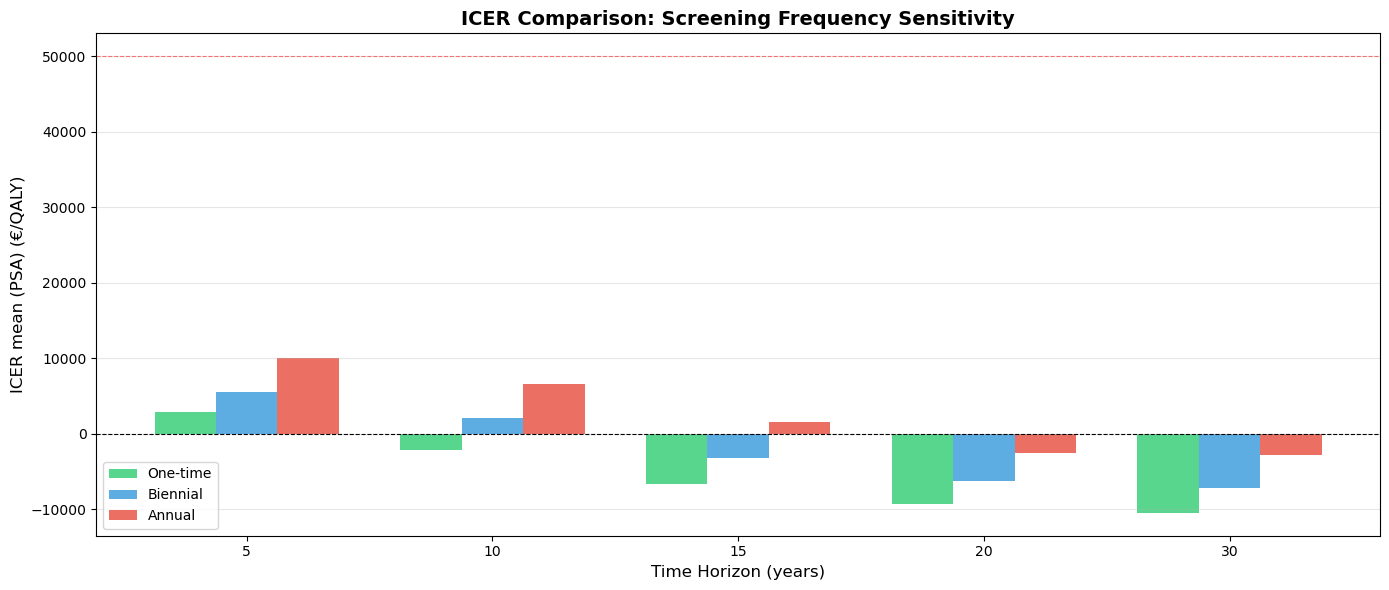

✓ ICER comparison plot saved to ../data/screening_freq_icer_comparison.png


In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

time_horizons = [5, 10, 15, 20, 30]
icers_onetime = [results_onetime['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]
icers_biennial = [results_biennial['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]
icers_annual = [results_annual['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]

x = np.arange(len(time_horizons))
width = 0.25

bars1 = ax.bar(x - width, icers_onetime, width, label='One-time', alpha=0.8, color='#2ecc71')
bars2 = ax.bar(x, icers_biennial, width, label='Biennial', alpha=0.8, color='#3498db')
bars3 = ax.bar(x + width, icers_annual, width, label='Annual', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('ICER mean (PSA) (€/QALY)', fontsize=12)
ax.set_title('ICER Comparison: Screening Frequency Sensitivity', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(time_horizons)
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.axhline(y=50000, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='€50k threshold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/screening_freq_icer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ICER comparison plot saved to ../data/screening_freq_icer_comparison.png")

### Probability of Cost-Effectiveness Comparison

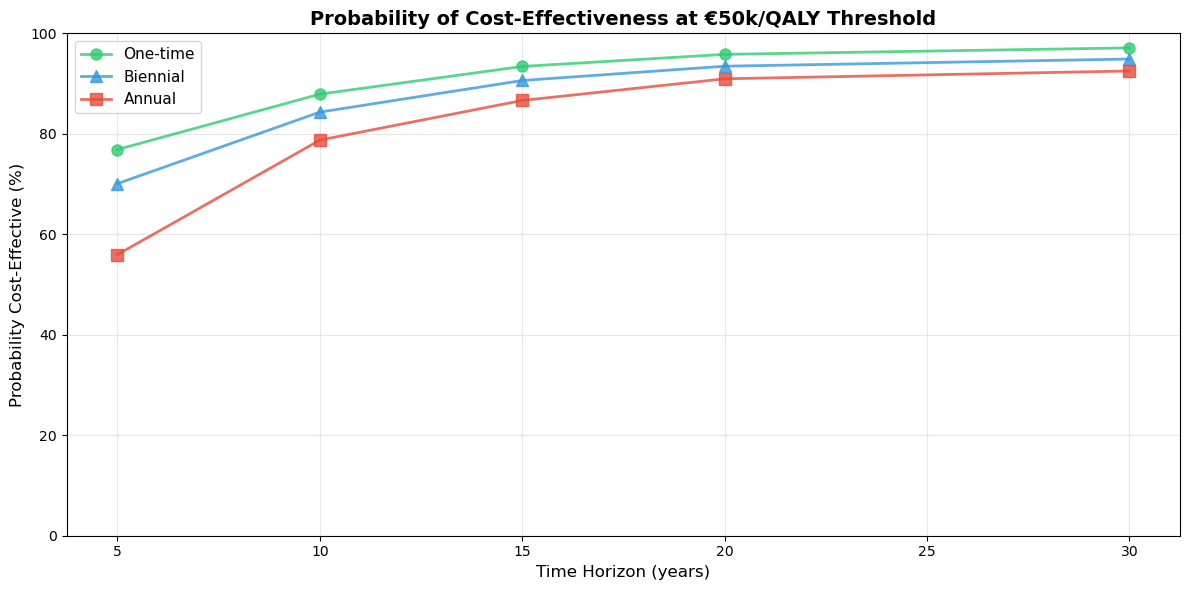

✓ Probability CE comparison plot saved to ../data/screening_freq_prob_ce_comparison.png


In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

prob_ce_onetime = [results_onetime['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]
prob_ce_biennial = [results_biennial['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]
prob_ce_annual = [results_annual['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]

ax.plot(time_horizons, prob_ce_onetime, marker='o', linewidth=2, markersize=8, label='One-time', alpha=0.8, color='#2ecc71')
ax.plot(time_horizons, prob_ce_biennial, marker='^', linewidth=2, markersize=8, label='Biennial', alpha=0.8, color='#3498db')
ax.plot(time_horizons, prob_ce_annual, marker='s', linewidth=2, markersize=8, label='Annual', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('Probability Cost-Effective (%)', fontsize=12)
ax.set_title('Probability of Cost-Effectiveness at €50k/QALY Threshold', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../data/screening_freq_prob_ce_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Probability CE comparison plot saved to ../data/screening_freq_prob_ce_comparison.png")

### Incremental Costs by Screening Frequency

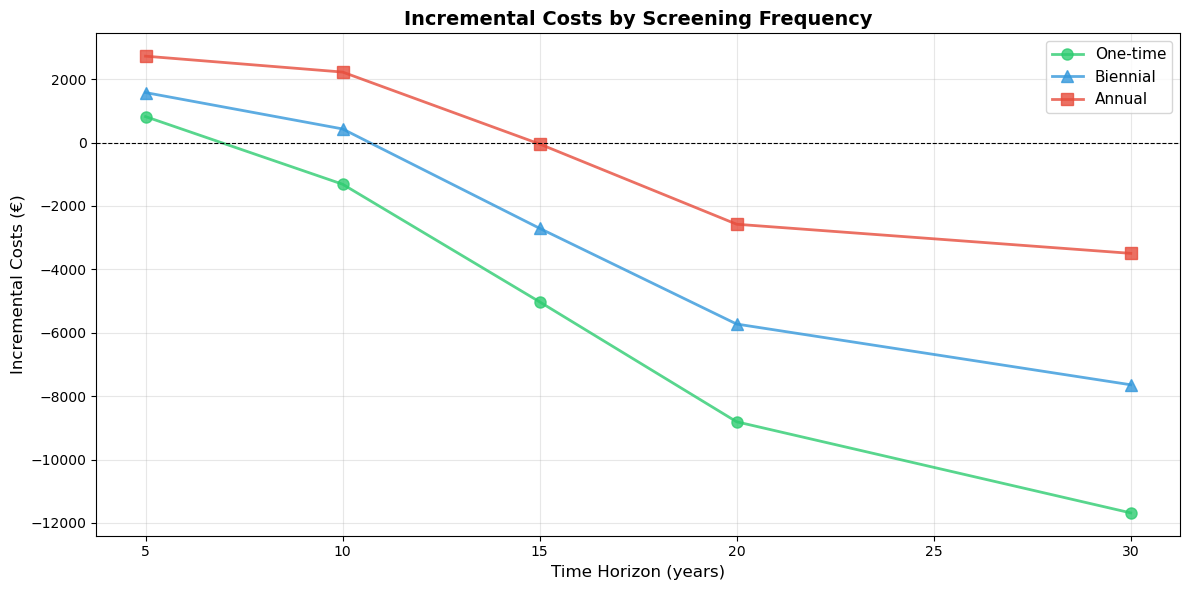

✓ Incremental costs plot saved to ../data/screening_freq_incremental_costs.png


In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

costs_onetime = [results_onetime['comprehensive_results'][f'{t}_years']['summary']['incremental_cost_mean'] for t in time_horizons]
costs_biennial = [results_biennial['comprehensive_results'][f'{t}_years']['summary']['incremental_cost_mean'] for t in time_horizons]
costs_annual = [results_annual['comprehensive_results'][f'{t}_years']['summary']['incremental_cost_mean'] for t in time_horizons]

ax.plot(time_horizons, costs_onetime, marker='o', linewidth=2, markersize=8, label='One-time', alpha=0.8, color='#2ecc71')
ax.plot(time_horizons, costs_biennial, marker='^', linewidth=2, markersize=8, label='Biennial', alpha=0.8, color='#3498db')
ax.plot(time_horizons, costs_annual, marker='s', linewidth=2, markersize=8, label='Annual', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('Incremental Costs (€)', fontsize=12)
ax.set_title('Incremental Costs by Screening Frequency', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.savefig('../data/screening_freq_incremental_costs.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Incremental costs plot saved to ../data/screening_freq_incremental_costs.png")

## Summary and Conclusions

In [23]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print("\n📊 Files saved:")
print("  - ../data/screening_freq_onetime_summary.csv")
print("  - ../data/screening_freq_biennial_summary.csv")
print("  - ../data/screening_freq_annual_summary.csv")
print("  - ../data/screening_freq_comparison.csv")
print("  - ../data/screening_freq_icer_comparison.png")
print("  - ../data/screening_freq_prob_ce_comparison.png")
print("  - ../data/screening_freq_incremental_costs.png")

print("\n📈 Key Findings (10-year horizon):")
print(f"  One-time: ICER = €{res_onetime['icer_mean']:,.0f}/QALY, Cost = €{res_onetime['incremental_cost_mean']:,.0f}")
print(f"  Biennial: ICER = €{res_biennial['icer_mean']:,.0f}/QALY, Cost = €{res_biennial['incremental_cost_mean']:,.0f}")
print(f"  Annual: ICER = €{res_annual['icer_mean']:,.0f}/QALY, Cost = €{res_annual['incremental_cost_mean']:,.0f}")

print("\n📊 Number of screening events over 30 years:")
print(f"  One-time: {results_onetime['num_screenings']} event")
print(f"  Biennial: {results_biennial['num_screenings']} events")
print(f"  Annual: {results_annual['num_screenings']} events")

print("\n💡 Interpretation:")
cost_increase_biennial = res_biennial['incremental_cost_mean'] - res_onetime['incremental_cost_mean']
cost_increase_annual = res_annual['incremental_cost_mean'] - res_onetime['incremental_cost_mean']

print(f"  Biennial screening increases costs by €{cost_increase_biennial:,.0f} compared to one-time")
print(f"  Annual screening increases costs by €{cost_increase_annual:,.0f} compared to one-time")
print(f"\n  ICER increase from one-time to biennial: €{res_biennial['icer_mean'] - res_onetime['icer_mean']:,.0f}/QALY")
print(f"  ICER increase from one-time to annual: €{res_annual['icer_mean'] - res_onetime['icer_mean']:,.0f}/QALY")

if res_biennial['prob_cost_effective_50k'] > 70:
    print("\n  Biennial screening remains cost-effective at €50k/QALY threshold.")
if res_annual['prob_cost_effective_50k'] > 70:
    print("  Annual screening remains cost-effective at €50k/QALY threshold.")
elif res_annual['prob_cost_effective_50k'] < 50:
    print("\n  Annual screening may not be cost-effective at €50k/QALY threshold.")

print("\n✓ All three scenarios have been successfully analyzed and compared.")


ANALYSIS COMPLETE

📊 Files saved:
  - ../data/screening_freq_onetime_summary.csv
  - ../data/screening_freq_biennial_summary.csv
  - ../data/screening_freq_annual_summary.csv
  - ../data/screening_freq_comparison.csv
  - ../data/screening_freq_icer_comparison.png
  - ../data/screening_freq_prob_ce_comparison.png
  - ../data/screening_freq_incremental_costs.png

📈 Key Findings (10-year horizon):
  One-time: ICER = €-10,457/QALY, Cost = €-11,683
  Biennial: ICER = €-7,160/QALY, Cost = €-7,642
  Annual: ICER = €-2,782/QALY, Cost = €-3,496

📊 Number of screening events over 30 years:
  One-time: 1 event
  Biennial: 16 events
  Annual: 31 events

💡 Interpretation:
  Biennial screening increases costs by €4,041 compared to one-time
  Annual screening increases costs by €8,187 compared to one-time

  ICER increase from one-time to biennial: €3,297/QALY
  ICER increase from one-time to annual: €7,675/QALY

  Biennial screening remains cost-effective at €50k/QALY threshold.
  Annual screening 